In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import glob
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

import sys
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
print("Adding to sys.path:", src_path)
sys.path.append(src_path)

from get_derived_features import get_hurst, get_basic_sentarc_features, detrend

Adding to sys.path: /Users/au324704/Desktop/fanfic_sentiment/src


In [2]:
# collect data from multiple JSON files into a single DataFrame
# get all jsons in results/partial_results_* and merge them into a single DataFrame
path = "../results/partial_results/MythFic_texts/"

files = glob.glob(os.path.join(path, "*.json"))
print(f"Found {len(files)} files in {path}")    

data = []
for file in files:
    print(f"Loading {file}")
    with open(file, 'r') as f:
        data.extend(json.load(f))

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data)
print('---------')
print('number of rows:', len(df))
df.head()

Found 52 files in ../results/partial_results/MythFic_texts/
Loading ../results/partial_results/MythFic_texts/partial_results_MythFic_texts_800_20250630_181004.json
Loading ../results/partial_results/MythFic_texts/partial_results_MythFic_texts_200_20250630_181004.json
Loading ../results/partial_results/MythFic_texts/partial_results_MythFic_texts_3500_20250630_181004.json
Loading ../results/partial_results/MythFic_texts/partial_results_MythFic_texts_4000_20250630_181004.json
Loading ../results/partial_results/MythFic_texts/partial_results_MythFic_texts_3800_20250630_181004.json
Loading ../results/partial_results/MythFic_texts/partial_results_MythFic_texts_500_20250630_181004.json
Loading ../results/partial_results/MythFic_texts/partial_results_MythFic_texts_3200_20250630_181004.json
Loading ../results/partial_results/MythFic_texts/partial_results_MythFic_texts_4700_20250630_181004.json
Loading ../results/partial_results/MythFic_texts/partial_results_MythFic_texts_4400_20250630_181004.jso

,text_id,vader,syuzhet,text,sentences,xlm-roberta-base-sentiment-multilingual
0,38314834,"[-0.2263, 0.2732, 0.8658, 0.6486, 0.0, 0.4404,...","[-0.5, -1.1, 1.5, 0.0, 0.0, 0.75, -0.25, -0.25...",The long forgotten Lady Asteria. Titaness of s...,"[The long forgotten Lady Asteria., Titaness of...","[-0.5675260424613953, 0.0, 0.8716139793395996,..."
1,38314492,"[-0.6908, -0.431, 0.0, 0.0, 0.0, 0.25, 0.0, 0....","[-0.75, -0.75, 0.0, 0.0, 0.1, 1.4, -0.4, 0.6, ...",They were going to kill him. Or maybe he was g...,"[They were going to kill him., Or maybe he was...","[-0.9134138226509094, -0.5431407690048218, 0.0..."
2,36510655,"[0.0, 0.0, 0.0, 0.0, -0.4939, 0.0, 0.4019, 0.0...","[0.0, 0.0, 0.4, 0.4, -0.75, 0.0, 0.65, 0.0, 0....","Sometimes, things happen behind-the-scenes tha...","[Sometimes, things happen behind-the-scenes th...","[0.0, 0.0, 0.0, 0.0, -0.6562243103981018, 0.0,..."
3,38307832,"[-0.3818, 0.0, 0.0, 0.7096, 0.7906, 0.5859, 0....","[-0.25, 0.0, 1.45, 0.0, 1.15, 1.75, 1.0, 1.1, ...",THE MIND OF THE SEA an insight into the god kn...,[THE MIND OF THE SEA an insight into the god k...,"[-0.6815999150276184, 0.0, 0.0, 0.796635329723..."
4,38306404,"[0.4404, 0.7003, -0.1027, 0.2732, -0.5994, 0.4...","[0.5, 3.1999999999999997, 0.25, 1.6, -0.75, 2....",Hera sends Lena the gift of a swan. Strong-win...,"[Hera sends Lena the gift of a swan., Strong-w...","[0.6996690034866333, 0.8971205353736877, 0.776..."


In [3]:
# drop duplicates
df = df.drop_duplicates(subset=['text_id']).reset_index(drop=True)
print('---------')
print('number of rows after dropping duplicates:', len(df))

# TEST
#df = df[:100]

---------
number of rows after dropping duplicates: 5090


Lets just do some checking, how are the lengths, anything look wrong?
Also plot some sentiment scores to see how they compare.

In [4]:
print(len(df['sentences'][1]))
print(len(df['syuzhet'][1]))
print(len(df['xlm-roberta-base-sentiment-multilingual'][1]))
print(len(df['text'][1].split('.'))) # seems like tokenization is done by sentence (approx)

326
326
326
322


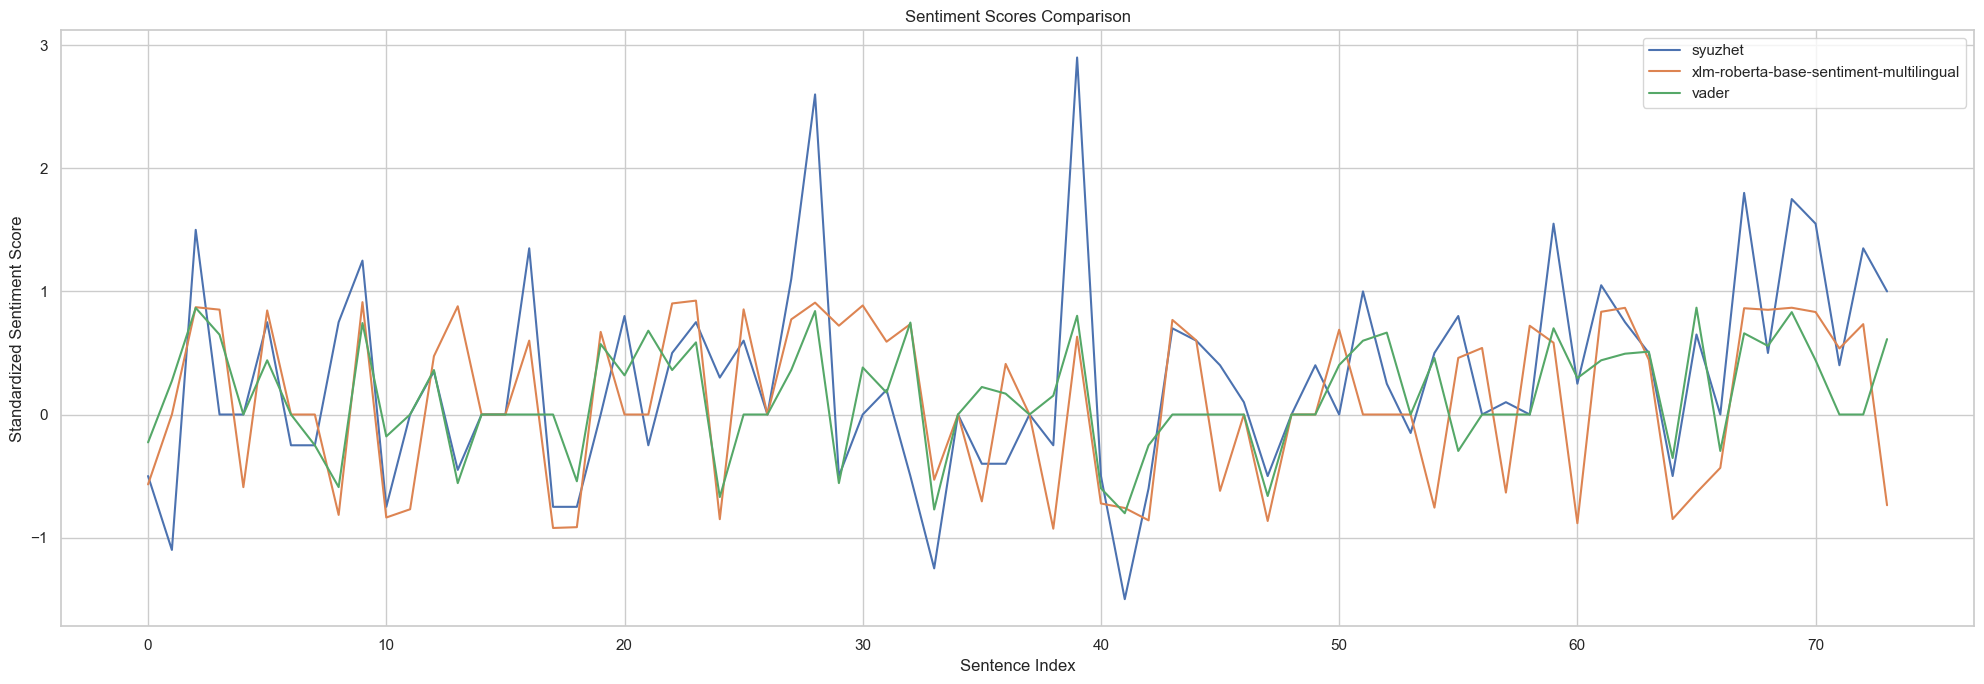

In [5]:
# let's plot the sentiment scores (vader, syuzhet, and xlm-roberta) for the first row
test_data = df.copy()
cols_to_scale = ['syuzhet', 'xlm-roberta-base-sentiment-multilingual', 'vader']
x_scores = 100  # number of sentences to plot

# Truncate first row's lists safely
first_row = {}
for col in cols_to_scale:
    first_row[col] = test_data.loc[0, col][:x_scores]

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(20, 7))
for col in cols_to_scale:
    plt.plot(first_row[col], label=col)
plt.title('Sentiment Scores Comparison')
plt.xlabel('Sentence Index')
plt.ylabel('Standardized Sentiment Score')
plt.legend()
plt.tight_layout()
plt.show()

# right, they are on different scales, so we should standardize

Okay lets get on with it

In [21]:
metadata = pd.read_csv("/Users/au324704/Downloads/transfer_3170830_files_331009ec/fanfics_Greek_myth_metadata.csv")
metadata.columns

Index(['work_id', 'title', 'author', 'rating', 'category', 'fandom',
       'relationship', 'character', 'additional tags', 'language', 'published',
       'status', 'status date', 'words', 'chapters', 'comments', 'kudos',
       'bookmarks', 'hits'],
      dtype='object')

In [22]:
# merge data w original df to get additional tags
#metadata = pd.read_csv("data/9000_fics.csv")
metadata = metadata[['work_id',
                     #'category', 
                     'fandom',
                     'additional tags', 
                    # 'language', 
                    'author',
                    'published']]

# rename work_id to text_id to match df
if "freeform" in metadata.columns:
    metadata.rename(columns={'freeform': 'additional_tags'}, inplace=True)

metadata.rename(columns={'work_id': 'text_id'}, inplace=True)
merged = df.merge(metadata, how='left', on='text_id')

# function to normalize the sentiment scores (they are on different scales)
def scale_sentiment_minmax(syuzhet_column):
    """ Scales the sentiment scores in the given column to a range of -1 to 1. """
    filtered = syuzhet_column.dropna().loc[syuzhet_column.apply(lambda x: isinstance(x, list) and len(x) > 0)]
    all_vals = np.concatenate(filtered.tolist()).reshape(-1, 1)
    
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(all_vals)
    
    return syuzhet_column.apply(
        lambda arc: scaler.transform(np.array(arc).reshape(-1, 1)).flatten().tolist()
        if isinstance(arc, list) and len(arc) > 0 else np.nan
    )

print(len(merged['syuzhet']))
print(metadata.columns)

5090
Index(['text_id', 'fandom', 'additional tags', 'author', 'published'], dtype='object')


In [23]:
# rename fandom to fandom_label
merged['fandom_label'] = "AGRL"

In [24]:
# lets get stats

# and all that per fandom
# sentences per fandom
sentences_per_fandom = merged.groupby('fandom_label')['sentences'].apply(lambda x: sum(len(s) for s in x if isinstance(s, list))).reset_index()
sentences_per_fandom.columns = ['fandom', 'total_sentences']
print("Total sentences per fandom:")
print(sentences_per_fandom)

# words per fandom
words_per_fandom = merged.groupby('fandom_label')['text'].apply(lambda x: sum(len(text.split()) for text in x if isinstance(text, str))).reset_index()
words_per_fandom.columns = ['fandom', 'total_words']
print("Total words per fandom:")
print(words_per_fandom)

# stories per fandom
stories_per_fandom = merged.groupby('fandom_label').size().reset_index(name='total_stories')
print("Total stories per fandom:")
print(stories_per_fandom)

Total sentences per fandom:
  fandom  total_sentences
0   AGRL          1966805
Total words per fandom:
  fandom  total_words
0   AGRL     25750546
Total stories per fandom:
  fandom_label  total_stories
0         AGRL           5090


In [25]:

### --- SETTING UP SENTIMENT ANALYSIS METHOD --- ###

# --- NB: you can choose which sentiment analysis method to use here ---
# (for all subsequent analyses, this will be used, i.e. you will plot values for this method)


METHOD_TO_USE = 'syuzhet'  # or 'vader' or 'twitter-xlm-roberta-base-sentiment-multilingual'
SCALE = False # whether to scale the sentiment scores or not before taking mean and std

methods = ['syuzhet', 'xlm-roberta-base-sentiment-multilingual']

# dropna on sentiment method to use
merged = merged.dropna(subset=[METHOD_TO_USE])

# we gotta introduce some threshold for the length -- sad -- but detrending is not possible for very short arcs
# so let's say 50 sentences min 
# we'll keep em, but will not detrend them
THRESHOLD = 50
# so adding a function to detrend only if the arc is long enough (detrend itself is defined in get_derived_features.py)
def detrend_if_long(arc):
    if isinstance(arc, list) and len(arc) > THRESHOLD:
        return detrend(arc) # detrend function from get_derived_features.py
    else:
        return np.nan

# make sure all arcs are lists
for method in methods:
    merged[method] = merged[method].apply(lambda x: float(x) if isinstance(x, str) else x)  # convert to float if not already
    merged[method] = merged[method].apply(lambda x: list(x) if isinstance(x, str) else x)  # convert to list if not already

# ---- extract features ---- #

for method in methods:
    if SCALE == True: # if we want to scale the sentiment scores prior to analysis
        merged[method] = scale_sentiment_minmax(merged[method])   
    # else:
    #     merged[method] = merged[method].apply(lambda x: list(x))

    # mean and SD
    merged[[f'mean_sent_{method}',f'sd_sent_{method}']] = merged[method].apply(lambda x: pd.Series(get_basic_sentarc_features(x)))
    # and detrending
    merged[f'detrended_arc_{method}'] = merged[method].apply(detrend_if_long)
    # option to get HURST
    #merged[f'hurst_{method}'] = merged[f'detrended_arc_{method}'].apply(lambda x: get_hurst(x) if isinstance(x, list) else np.nan)

# drop some nans
merged = merged.dropna(subset=['detrended_arc_syuzhet'])

print("len of notna when detrending arcs (-short texts):", len(merged))
print("len of original df:", len(df))
merged.head(2)


len of notna when detrending arcs (-short texts): 3584
len of original df: 5090


,text_id,vader,syuzhet,text,sentences,xlm-roberta-base-sentiment-multilingual,fandom,additional tags,author,published,fandom_label,mean_sent_syuzhet,sd_sent_syuzhet,detrended_arc_syuzhet,mean_sent_xlm-roberta-base-sentiment-multilingual,sd_sent_xlm-roberta-base-sentiment-multilingual,detrended_arc_xlm-roberta-base-sentiment-multilingual
0,38314834,"[-0.2263, 0.2732, 0.8658, 0.6486, 0.0, 0.4404,...","[-0.5, -1.1, 1.5, 0.0, 0.0, 0.75, -0.25, -0.25...",The long forgotten Lady Asteria. Titaness of s...,"[The long forgotten Lady Asteria., Titaness of...","[-0.5675260424613953, 0.0, 0.8716139793395996,...",Ancient Greek Religion & Lore,I was possessed by her spirit to write this an...,['Mx_Night'],2022-04-11,AGRL,0.291216,0.806869,"[-0.7580792347147487, -0.7138991157682747, -0....",0.114219,0.656464,"[0.26250261084888793, 0.18534410726136152, 0.1..."
1,38314492,"[-0.6908, -0.431, 0.0, 0.0, 0.0, 0.25, 0.0, 0....","[-0.75, -0.75, 0.0, 0.0, 0.1, 1.4, -0.4, 0.6, ...",They were going to kill him. Or maybe he was g...,"[They were going to kill him., Or maybe he was...","[-0.9134138226509094, -0.5431407690048218, 0.0...","The Iliad - Homer, The Odyssey - Homer, Hades ...","Getting Together, Toxic Masculinity, era appro...",['FlaviaFulvia'],2022-04-11,AGRL,0.059049,0.828658,"[0.6441372373089567, 0.6412851480410899, 0.638...",-0.231827,0.512815,"[-1.0, -0.9758608631150534, -0.951721726230106..."


In [77]:
# # try out sinuoisity measure (could give us an idea of the "rollercoaster"-ness of the sentiment arc)
# this is just some playtime, not sure that this would work and how well my function works
# from src.get_derived_features import get_sinuosity

# test0 = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
# print("Sinuosity of test arc:", get_sinuosity(test0))
# test2 = [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0.5, 0.5, 0.5, 0.5, 0.5]
# print("Sinuosity of test2 arc:", get_sinuosity(test2))
# test3 = [0, 0.5, 0, 1, 0, 0.5, 0, 1, 0, 0.5, 0, 1, 0, 0.5, 0, 1]
# print("Sinuosity of test3 arc:", get_sinuosity(test3))

# # get sinuosity
# merged['sinuosity'] = merged['detrended_arc'].apply(lambda x: get_sinuosity(x))
# # probably we want to do this on the detrended arcs, or change to METHOD_TO_USE (i.e., raw sentiment, selected method)

# # print number of nans in sinuosity
# print("Number of NaNs in sinuosity:", merged['sinuosity'].isna().sum())

In [27]:
# now we want to tag "fluff" and "angst" and "hurt/comfort" if those are in the additional tags

# rename additional tags to match the tagging code from Julia
merged.rename(columns={'additional tags': 'additional_tags'}, inplace=True)

# function adopted to match the tagging code from Julia
def tag_genre(tags):
    if not isinstance(tags, str):
        return 'other'

    tag_list = [tag.strip().lower() for tag in tags.split(',')]
    tag_str = ' '.join(tag_list)

    # Exclusion stuff --> other
    exclusions = ['angst and fluff', 'flangst']

    # Check presence of specific tags
    has_fluff = 'fluff' in tag_str
    has_angst = 'angst' in tag_str
    has_hurt_comfort = 'hurt/comfort' in tag_str or 'hurt comfort' in tag_str

    # Fluff only if it has fluff and none of the others
    if has_fluff and not has_angst and not has_hurt_comfort and not any(ex in tag_str for ex in exclusions):
        return 'fluff'

    # Angst only if it has angst and none of the others
    if has_angst and not has_fluff and not has_hurt_comfort and not any(ex in tag_str for ex in exclusions):
        return 'angst'

    # Hurt/Comfort only if it has hc and none of the others
    if has_hurt_comfort and not has_fluff and not has_angst and not any(ex in tag_str for ex in exclusions):
        return 'hurt/comfort'

    # Anything else is 'other'
    return 'other'

# apply
merged['subset'] = merged['additional_tags'].apply(tag_genre)
print(merged['subset'].value_counts())

# nice, so make groups by subset now
fluff = merged[merged['subset'] == 'fluff']
angst = merged[merged['subset'] == 'angst']
hurt_comfort = merged[merged['subset'] == 'hurt/comfort']
other = merged[merged['subset'] == 'other']

# print lens
print("--- Categories and their counts: ---")
print(f"Angst: {len(angst)}")
print(f"Fluff: {len(fluff)}")
print(f"Hurt/Comfort: {len(hurt_comfort)}")
print(f"Other: {len(other)}")

merged.head(2)

subset
other           2940
angst            290
fluff            268
hurt/comfort      86
Name: count, dtype: int64
--- Categories and their counts: ---
Angst: 290
Fluff: 268
Hurt/Comfort: 86
Other: 2940


,text_id,vader,syuzhet,text,sentences,xlm-roberta-base-sentiment-multilingual,fandom,additional_tags,author,published,fandom_label,mean_sent_syuzhet,sd_sent_syuzhet,detrended_arc_syuzhet,mean_sent_xlm-roberta-base-sentiment-multilingual,sd_sent_xlm-roberta-base-sentiment-multilingual,detrended_arc_xlm-roberta-base-sentiment-multilingual,subset
0,38314834,"[-0.2263, 0.2732, 0.8658, 0.6486, 0.0, 0.4404,...","[-0.5, -1.1, 1.5, 0.0, 0.0, 0.75, -0.25, -0.25...",The long forgotten Lady Asteria. Titaness of s...,"[The long forgotten Lady Asteria., Titaness of...","[-0.5675260424613953, 0.0, 0.8716139793395996,...",Ancient Greek Religion & Lore,I was possessed by her spirit to write this an...,['Mx_Night'],2022-04-11,AGRL,0.291216,0.806869,"[-0.7580792347147487, -0.7138991157682747, -0....",0.114219,0.656464,"[0.26250261084888793, 0.18534410726136152, 0.1...",other
1,38314492,"[-0.6908, -0.431, 0.0, 0.0, 0.0, 0.25, 0.0, 0....","[-0.75, -0.75, 0.0, 0.0, 0.1, 1.4, -0.4, 0.6, ...",They were going to kill him. Or maybe he was g...,"[They were going to kill him., Or maybe he was...","[-0.9134138226509094, -0.5431407690048218, 0.0...","The Iliad - Homer, The Odyssey - Homer, Hades ...","Getting Together, Toxic Masculinity, era appro...",['FlaviaFulvia'],2022-04-11,AGRL,0.059049,0.828658,"[0.6441372373089567, 0.6412851480410899, 0.638...",-0.231827,0.512815,"[-1.0, -0.9758608631150534, -0.951721726230106...",other


In [28]:
# fluff, angst, hurt/comfort, other per fandom counts
fandom_counts = merged.groupby(['fandom_label', 'subset']).size().unstack(fill_value=0).reset_index()
fandom_counts.columns.name = None  # remove the name of the columns
fandom_counts = fandom_counts.rename(columns={'fandom_label': 'fandom'})
print("Fandom counts by subset:")
print(fandom_counts)

Fandom counts by subset:
  fandom  angst  fluff  hurt/comfort  other
0   AGRL    290    268            86   2940


In [29]:
# Now we want to just check the distributions of the data over the tags 
dataset_name = path.split('/')[-2]  # e.g., '9000_fics'


sns.set_style("whitegrid")

alpha = 0.4 # transparency for the histograms
feature = 'hurst' #'mean_sent' # 'sd_sent'  'hurst' #feature to plot
# add the method_to_use to the feature name
feature_mod = f'{feature}_{METHOD_TO_USE}'  # will be e.g., 'mean_sent_syuzhet'

# we want a histplot of syuzhet scores for each subset
plt.figure(figsize=(15, 5))
sns.histplot(fluff[feature_mod], color='blue', label='Fluff', kde=True, stat="density", alpha=alpha)
sns.histplot(angst[feature_mod], color='red', label='Angst', kde=True, stat="density", alpha=alpha)
sns.histplot(hurt_comfort[feature_mod], color='green', label='Hurt/Comfort', kde=True, stat="density", alpha=alpha)
sns.histplot(other[feature_mod], color='purple', label='Other', kde=True, stat="density", alpha=alpha)   
plt.title(f'{feature} ({METHOD_TO_USE}) by subset')
plt.xlabel(f'feature')
plt.ylabel('Density')

if feature == 'hurst' or feature == 'sd_sent':
    # Set xlim for hurst to be between 0 and 1
    plt.xlim(0.2, 1)
else:
    # Set xlim for sd_sent to be between 0 and 1
    plt.xlim(-1, 1) # since we scaled sentiment to [-1, 1]
plt.legend()
plt.savefig(f'../results/figs/{feature}_by_subset_{METHOD_TO_USE}_{dataset_name}.png', dpi=300)

KeyError: 'hurst_syuzhet'

<Figure size 1500x500 with 0 Axes>

/var/folders/z1/0qk3lyhj5r70_82k9y09_x15zptf_4/T/ipykernel_12724/2911275324.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


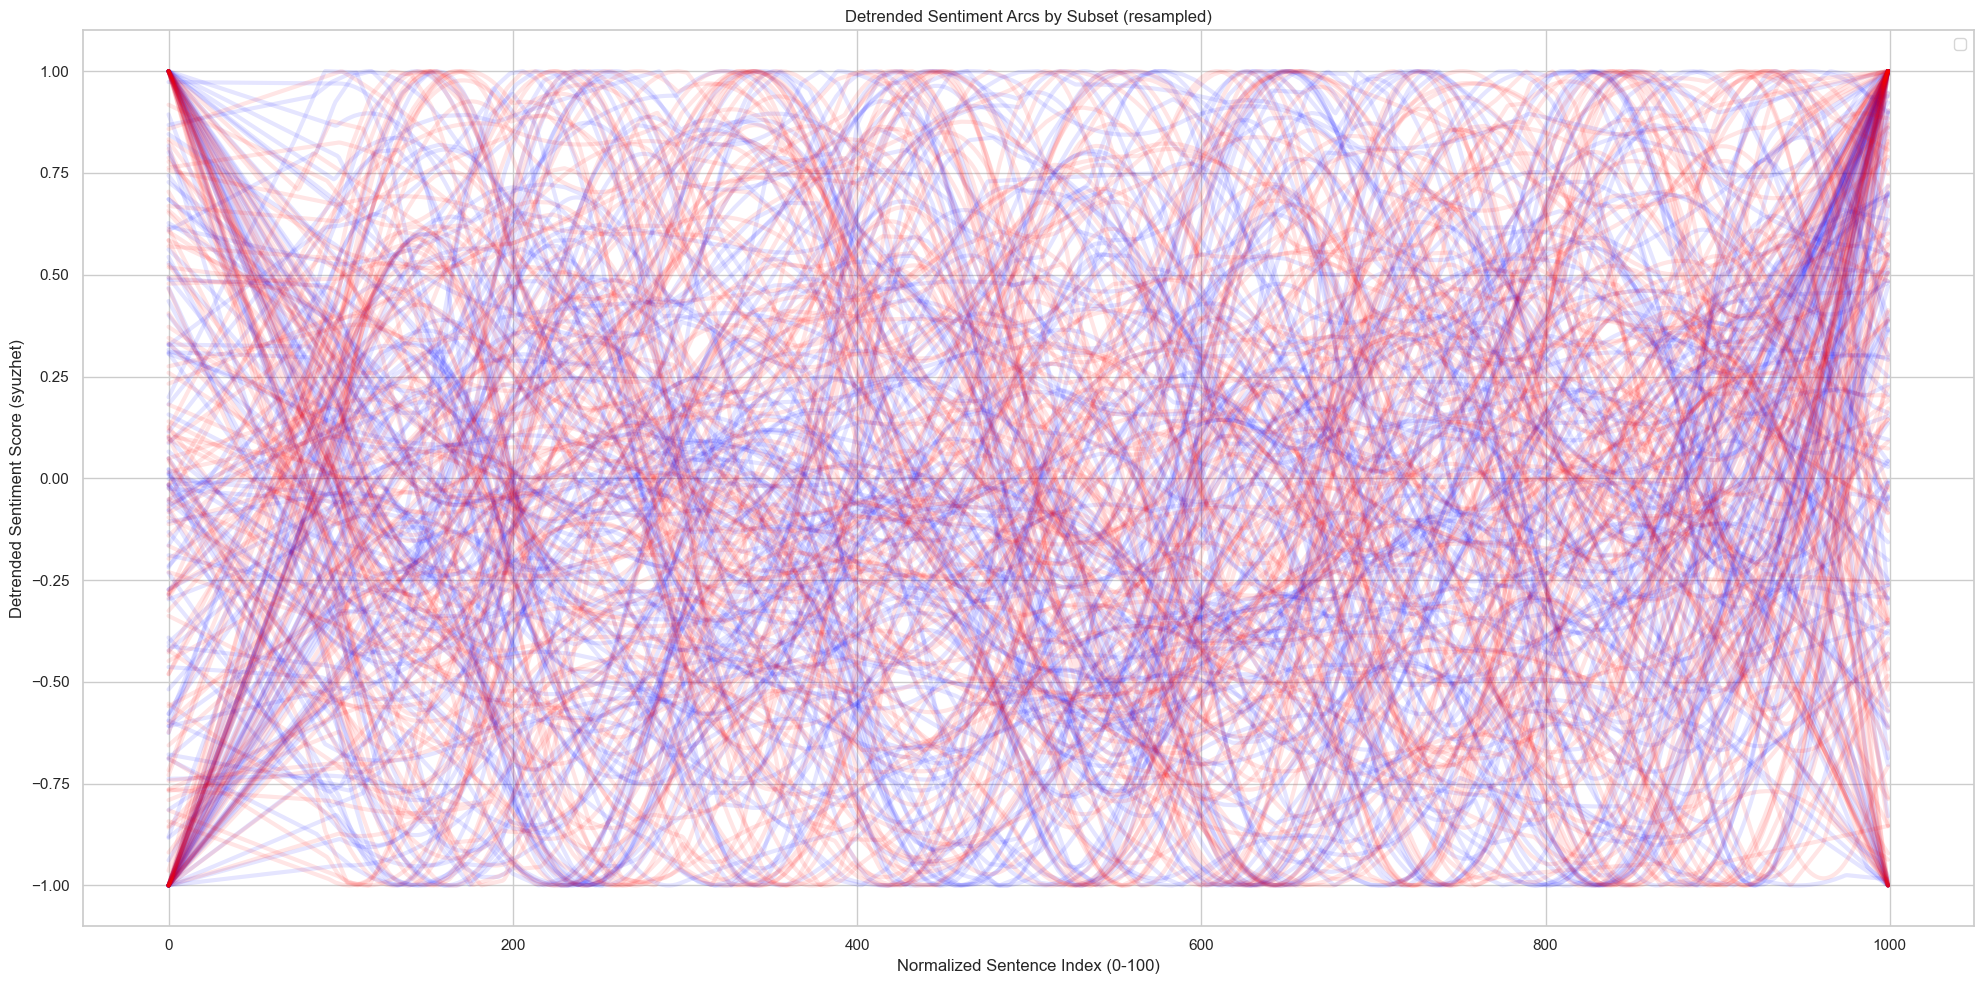

In [34]:
data = merged.dropna(subset=['detrended_arc_syuzhet'])

# functions to resample arcs to a fixed length for better comparison
# this is useful for plotting, since arcs can have different lengths
def resample_arc(arc, target_length):
    arc = np.array(arc)
    original_indices = np.linspace(0, 1, num=len(arc))
    target_indices = np.linspace(0, 1, num=target_length)
    return np.interp(target_indices, original_indices, arc)

plt.figure(figsize=(20, 10))

def plot_resampled_arcs(arcs_df, label, color, target_length=1000):
    for arc in arcs_df[f'detrended_arc_{METHOD_TO_USE}']:
        resampled = resample_arc(arc, target_length)
        plt.plot(resampled, alpha=0.1, color=color, linewidth=3)

# SAMPLING
# right we probably want to balance the groups for this plot (so each group is the same size)
min_len = min(len(fluff_arc), len(angst_arc)) # len(hurt_comfort_arc), len(other_arc))
#min_len = 2 # uncomment this to just plot 2 arcs per group (to inspect)

fluff_arc_bal = fluff_arc.sample(min_len, random_state=42)
angst_arc_bal = angst_arc.sample(min_len, random_state=42)
# hurt_comfort_arc_bal = hurt_comfort_arc.sample(min_len, random_state=42)

plot_resampled_arcs(fluff_arc_bal, 'Fluff', 'blue')
plot_resampled_arcs(angst_arc_bal, 'Angst', 'red')
#plot_resampled_arcs(hurt_comfort_arc, 'Hurt/Comfort', 'blue')

plt.title('Detrended Sentiment Arcs by Subset (resampled)')
plt.xlabel('Normalized Sentence Index (0-100)')
plt.ylabel(f'Detrended Sentiment Score ({METHOD_TO_USE})')
plt.legend()
plt.tight_layout()
plt.show()

# doesnt give us much info anyway
# looks like a bit more red in the lower right corner.......

In [43]:
merged.columns

Index(['text_id', 'vader', 'syuzhet', 'text', 'sentences',
       'xlm-roberta-base-sentiment-multilingual', 'fandom', 'additional_tags',
       'author', 'mean_sent_syuzhet', 'sd_sent_syuzhet',
       'detrended_arc_syuzhet', 'hurst_syuzhet',
       'mean_sent_xlm-roberta-base-sentiment-multilingual',
       'sd_sent_xlm-roberta-base-sentiment-multilingual',
       'detrended_arc_xlm-roberta-base-sentiment-multilingual',
       'hurst_xlm-roberta-base-sentiment-multilingual', 'subset'],
      dtype='object')

Mean Sentiment Tests:
fluff_vs_angst: 
 t-statistic = nan, p-val = nan, 
 U-statistic = nan, p-val = nan
fluff_vs_hurt_comfort: 
 t-statistic = nan, p-val = nan, 
 U-statistic = nan, p-val = nan
fluff_vs_other: 
 t-statistic = nan, p-val = nan, 
 U-statistic = nan, p-val = nan
angst_vs_hurt_comfort: 
 t-statistic = nan, p-val = nan, 
 U-statistic = nan, p-val = nan
angst_vs_other: 
 t-statistic = nan, p-val = nan, 
 U-statistic = nan, p-val = nan
hurt_comfort_vs_other: 
 t-statistic = nan, p-val = nan, 
 U-statistic = nan, p-val = nan


/Users/au324704/.pyenv/versions/3.11.1/lib/python3.11/site-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
/var/folders/z1/0qk3lyhj5r70_82k9y09_x15zptf_4/T/ipykernel_12724/4250554525.py:6: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  u_stat, p_value_u = mannwhitneyu(df1[column].dropna(), df2[column].dropna())
/Users/au324704/.pyenv/versions/3.11.1/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/au324704/.pyenv/versions/3.11.1/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


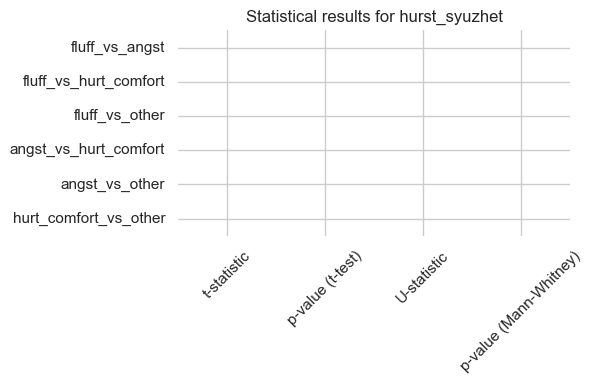

In [ ]:
# get ttest, mannwhitney for hurst and mean_sent
from scipy.stats import ttest_ind, mannwhitneyu

def perform_tests(df1, df2, column):
    t_stat, p_value_t = ttest_ind(df1[column].dropna(), df2[column].dropna())
    u_stat, p_value_u = mannwhitneyu(df1[column].dropna(), df2[column].dropna())
    return t_stat, p_value_t, u_stat, p_value_u

# Perform tests for X factor
measure = 'hurst' #'hurst', 'sd_sent', 'sinuosity'    
# add the method to the measure
measure = f'{measure}_{METHOD_TO_USE}'

if measure == 'hurst':
    # dropna
    dfs = [fluff, angst, hurt_comfort, other]
    # drop
    for df in dfs:
        df.dropna(subset=[f'detrended_arc_{METHOD_TO_USE}'], inplace=True)

mean_sent_tests = {
    'fluff_vs_angst': perform_tests(fluff, angst, measure),
    'fluff_vs_hurt_comfort': perform_tests(fluff, hurt_comfort, measure),
    'fluff_vs_other': perform_tests(fluff, other, measure),
    'angst_vs_hurt_comfort': perform_tests(angst, hurt_comfort, measure),
    'angst_vs_other': perform_tests(angst, other, measure),
    'hurt_comfort_vs_other': perform_tests(hurt_comfort, other, measure)
}   

print("Mean Sentiment Tests:")
for key, value in mean_sent_tests.items():
    print(f"{key}: \n t-statistic = {value[0]}, p-val = {round(value[1],3)}, \n U-statistic = {value[2]}, p-val = {round(value[3],3)}")

# make it into a heatmap
results_df = pd.DataFrame(mean_sent_tests, index=['t-statistic', 'p-value (t-test)', 'U-statistic', 'p-value (Mann-Whitney)']).T
# scale the u statistic, /1000
results_df['U-statistic'] = results_df['U-statistic'] / 10000
# Set up the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(results_df, annot=True, fmt=".3f", cmap='Blues', cbar=False)
plt.title(f'Statistical results for {measure}')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'../results/figs/stats_{measure}_by_subset_{METHOD_TO_USE}.png', dpi=300)

In [30]:
# export stuff to data, if you want
if not os.path.exists('data'):
    os.makedirs('data')

# export merged df to csv
merged.to_csv(f'../data/merged_sentiment_data_{dataset_name}.csv', index=False)